# SMOTEBook

In this notebook, we'll explore some sampling techniques designed to balance the representation of classes in a dataset.  In particular, we'll look at the SMOTE family of algorithms.  First, we will import necessary packages.

In [41]:
import numpy as np
import pandas as pd
import warnings

import imblearn

## What is an imbalanced dataset?

An imbalanced dataset is a labeled dataset where the classes represented do not have a uniform representation.  For example, in the Ecoli dataset {cite}`misc_ecoli_39`, we are trying to predict the localization cite in gram-negative bacteria "Expert System for Predicting Protein Localization Sites in Gram-Negative Bacteria (1991)."  The class to predict has an imbalanced distribution.  We can see this in the data import block below.

In [2]:
ecoli = pd.DataFrame(columns=['seq_name','mcg','gvh','lip','chg','aac','alm1','alm2','site'])
with open("ecoli.data") as file:
    for line in file:
        new_row = line.split()
        ecoli.loc[len(ecoli)] = new_row
        
ecoli['site'].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: site, dtype: int64

We can see that cytoplasm (cp) is the most frequently observed localization cite for the bacteria (143 instances), while some classes have very little representation in the data (for example, inner membrane lipoprotein (imL) with only 2 instances).  This tends to create a bias in classification algorithms.  A classifier can just predict the most frequent class for instances it isn't sure about and still achieve a good accuracy on test data.  This problem is exacerbated when the dataset classes are binary.

There are algorithms that aim to even the representation of the classes by either undersampling or oversampling certain classes.  Here, we'll discuss some undersampling techniques and some oversampling techniques, notably the SMOTE algorithm and some of its variants.

## Random Undersampling

The simplest undersampling method we will discuss is random undersampling.  With random undersampling, we decrease the number of majority class instances in $\mathcal{L}$ so that we underrepresent the majority class and focus more on the minority class.  Samples are randomly discarded from the majority class until the number of instances in the majority class is equivalent to the number of instances in the minority class.  In the situation where we have more than two classes, we repeat this process over each class.

## Centroid Undersampling

A more complicated undersampling method we use is centroid undersampling.  To describe centroid undersampling, we first explain Lloyd's algorithm \cite{lloyd_least_1982} for finding $k$-means.  First, we start with $k$ samples from $\mathcal{L}$ as our initial centroids.  These $k$ samples are called seeds and can be chosen using algorithms such as kmeans++ [citation] or by randomly selecting $k$ samples from $\mathcal{L}$.  Let $Q_{a}^{(i)}$ be the $a$th cluster on iteration $i$, where $Q_{a}^{(0)}$ is the initial seed for cluster $a$, and let $\beta>0$ be a tolerance.  We will loop between the following two steps.\\
1. We assign each sample $\mathbf{x}\in\mathcal{L}$ to the cluster $Q_{a}^{(i)}$ such that $\mathbf{x}$ is closest to the cluster's centroid $q_{a}^{(i)}$.  In other words, $$Q_{a}^{(i)}\supset\left\{  \mathbf{\mathbf{x}\in\mathcal{L}}\,|\,(q_{a}^{(i)} - \mathbf{x})^{2} < (q_{b}^{(i)}-\mathbf{x})^{2}\text{ for }a,b = 1,2,\dots,k\text{ where } a\neq b \right\}$$
2. We create new centroids $q_{a}^{(i)}$ for each cluster $Q_{a}^{(i)}$ by taking the averages for each cluster.  We then calculate $$S^{(i)}=\sum_{j=0}^{N}\min_{1\leq a\leq k}( \mid\mid x_{j}-q_{a}\mid\mid^{2} ).$$
We break the loop when $S^{(i)}-S^{(i-1)}<\beta$.
This is the general method for finding centroids.  To perform centroid undersampling, we pick a number $K$.  This number is usually the number of samples in the minority class.  We then apply the $K$-means algorithm to the majority class to find $K$ centroids in the class.  Once these centroids are found, they replace the existing samples of the majority class.  In the case of binary data, this should result in the same number of instances in each class.  In the multiclass scenario, we repeat the centroid undersampling method for each nonminority class, so that all classes end with the same number of instances.

## SMOTE and Variants

In the presence of an imbalanced dataset, a sampling technique we may wish to apply is the Synthetic Minority Oversampling Technique (SMOTE) \cite{nvc2002}. The authors of the algorithm note that oversampling with replacement doesn't necessarily increase a classifier's ability to recognize the minority class.  As the minority class is oversampled, more and more, the decision region for this class becomes more specific, which leads to classifiers that don't excel at generalization.  The authors propose an algorithm where synthetic instances in the minority class are generated using existing instances of the class in the dataset.  To generate these examples, the $k$ minority class nearest neighbors are found for each example in the minority class and points are selected on the line segments between these examples at random to become new samples.
Mathematically, the samples are formed by taking the difference between the feature vector at hand and one of its nearest neighbors.  This difference is then multiplied by a number from $Unif(0,1)$ and added to the original feature vector.  As a result, we now have a new instance of the minority class on the connecting line.  The effect of this process creates a more general decision region for the minority class.

### SMOTE + Tomek Links (SMOTETomek)
One downside of the SMOTE algorithm is its tendency to create noisy data in the presence of classes that are not clearly defined.  For example, suppose there exist classes $c_{1}$ and $c_{2}$ such that for some feature vector $\mathbf{x}$ in $\mathcal{L}$, $\mathbf{x}\in c_{1}$ if $\mathbf{x}\geq \sum_{1\leq i\leq m}\beta_{i}x_{i}$ for some $\beta_{i}\in\mathbb{R}$, $i=1,2,\dots,m$ and $\mathbf{x}\in c_{2}$ otherwise.  This definition gives a linear separation between the two classes.  Now, suppose this relationship is true for all but a few instances classified as either $c_{1}$ or $c_{2}$.  These instances, in a sense, violate the decision region for these classes.  If we perform the SMOTE algorithm using any of these instances, the decision region becomes even murkier. 

There are some procedures that allow for a kind of "noise removal" of cloudy data.  Researchers have applied some of these to data created by SMOTEing another dataset with great success.  One of these techniques is the use of Tomek links \cite{noauthor_two_1976}.  As described in \cite{batista_balancing_2003}, suppose we have two examples $\mathbf{u}$ and $\mathbf{v}$ from $\mathcal{L}_{x}$ and suppose these two examples are from different classes.  The pair $(\mathbf{u},\mathbf{v})$ is called a Tomek link if there is not an instance $\mathbf{z}\in\mathcal{L}_{x}$ such that for a distance $d$, $d(\mathbf{u},\mathbf{z})<d(\mathbf{u},\mathbf{v})$ or $d(\mathbf{v},\mathbf{z})<d(\mathbf{v},\mathbf{u})$.  If a pair of instances forms a Tomek link, we consider one of the examples "noise" or both of them are on the borderline of the decision boundary.  We remove the instance from the majority class as to not lose a precious instance from the minority class.

In the imblearn package for Python, Tomek links are determined by finding whether two instances, say $\mathbf{u}$ and $\mathbf{v}$, are both nearest neighbors to one another using scikit learn's implementation of the nearest neighbors algorithm.  By default, sklearn uses the Minkowski distance $$\lvert \lvert \mathbf{u}-\mathbf{v} \rvert  \rvert_{p} = \left( \sum_{i=1}^{n}\lvert u_{i}-v_{i} \rvert^{p}  \right)^{1/p}$$
with $p=2$.  This is the generalization of the Euclidean norm to higher dimensions.

### SMOTE + Wilson's Edited Nearest Neighbor rule (SMOTEENN)
Another noise reduction technique relevant to our study is Wilson's Edited Nearest Neighbor method \cite{wilson_asymptotic_1972}.  Let $\mathcal{L}_{x} = \{ \mathbf{x}_{1}, \mathbf{x}_{2},\dots,\mathbf{x}_{N} \}$ be the feature vectors of $\mathcal{L}$.  We perform noise reduction in the following manner.  For each $i = 1,2,\dots,N$, find the $k$-nearest neighbors to $\mathbf{x}_{i}$ in the set $\mathcal{L}_{x}-\{ \mathbf{x}_{i} \}$.  Find the most frequent class assigned to instances among the $k$-nearest neighbors, breaking ties randomly when needed.  If the class of $\mathbf{x}_{i}$ differs from this most frequent class, remove $(\mathbf{x}_{i},c_{i})$ from $\mathcal{L}$.

Wilson \cite{wilson_asymptotic_1972} developed theoretical properties and suggested using $k=3$ nearest neighbors provides favorable conditions in regards to the Bayes' risk.  Hence this is what we use after applying the SMOTE technique.

Gustav, et al. \cite{bgustav2004} note that compared to using Tomek links, using Wilson's Edited Nearest Neighbors provides a deeper cleaning of the data.  We should also mention that this technique also removes instances from any class, not just the majority class. 

## Simulations

Here, we will perform each of the the sampling methods mentioned previously on a simulated dataset.  This dataset has two features, and the instances in this dataset will belong to three different classes (0, 1, and 2).  Class 0 contains 10 instances, Class 1 contains 25, and Class 3 50.  Below shows plots of the original set and the set after sampling with these methods.

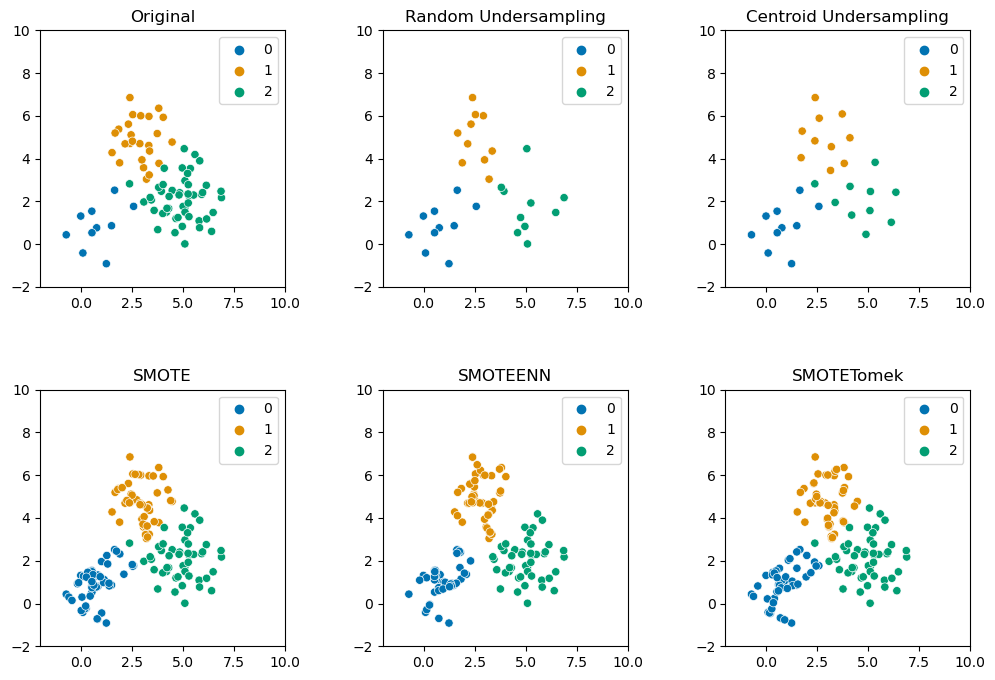

In [53]:
warnings.simplefilter('ignore')

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns

n_samples = [10,25,50]
centers = [(1, 1), (3, 5), (5, 2)]
x, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

# creating various Sampler instances
Smote = imblearn.over_sampling.SMOTE()
Rus = imblearn.under_sampling.RandomUnderSampler()
Cus = imblearn.under_sampling.ClusterCentroids()
SmoteENN = imblearn.combine.SMOTEENN()
SmoteTomek = imblearn.combine.SMOTETomek()

# fitting the Sampler objects
x_rus, y_rus = Rus.fit_resample(x,y)
x_cus, y_cus = Cus.fit_resample(x,y)
x_smote, y_smote = Smote.fit_resample(x,y)
x_smoteenn, y_smoteenn = SmoteENN.fit_resample(x,y)
x_smotetomek, y_smotetomek = SmoteTomek.fit_resample(x,y)

# Creating plots
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot for original training set
ax1 = fig.add_subplot(2,3,1)
sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, palette="colorblind", ax=ax1)
ax1.set_title("Original")
ax1.set_xbound(-2,10)
ax1.set_ybound(-2,10)

# plot for randomly undersampled set
ax2 = fig.add_subplot(2,3,2)
sns.scatterplot(x=x_rus[:,0], y=x_rus[:,1], hue=y_rus, palette="colorblind", ax=ax2)
ax2.set_title("Random Undersampling")
ax2.set_xbound(-2,10)
ax2.set_ybound(-2,10)

# plot for centroid undersampled set
ax3 = fig.add_subplot(2,3,3)
sns.scatterplot(x=x_cus[:,0], y=x_cus[:,1], hue=y_cus, palette="colorblind", ax=ax3, )
ax3.set_title("Centroid Undersampling")
ax3.set_xbound(-2,10)
ax3.set_ybound(-2,10)

# plot for SMOTE'd set
ax4 = fig.add_subplot(2,3,4)
sns.scatterplot(x=x_smote[:,0], y=x_smote[:,1], hue=y_smote, palette="colorblind", ax=ax4)
ax4.set_title("SMOTE")
ax4.set_xbound(-2,10)
ax4.set_ybound(-2,10)

# plot for SMOTEENN set
ax5 = fig.add_subplot(2,3,5)
sns.scatterplot(x=x_smoteenn[:,0], y=x_smoteenn[:,1], hue=y_smoteenn, palette="colorblind", ax=ax5)
ax5.set_title("SMOTEENN")
ax5.set_xbound(-2,10)
ax5.set_ybound(-2,10)

# plot for SMOTETomek set
ax6 = fig.add_subplot(2,3,6)
sns.scatterplot(x=x_smotetomek[:,0], y=x_smotetomek[:,1], hue=y_smotetomek, palette="colorblind", ax=ax6)
ax6.set_title("SMOTETomek")
ax6.set_xbound(-2,10)
ax6.set_ybound(-2,10)

plt.show()

We can see above that the undersampling methods remove instances from the non-minority classes in different manners, with centroid undersampling notably resulting in class instances that are more "equidistant" from each other.  The SMOTE algorithms seem to fill out the convex hull for each class, where the ENN and Tomek variants remove some of the instances that blur the decision boundarys between the classes.

Now, let's return to the Ecoli dataset to see how these sampling methods perform on real data.  The Ecoli dataset contains 7 features for each instance.  The least frequent classes only contain 2 instances.  We will modify the SMOTE algorithms to interpolate between 2 nearest neighbors for this reason (by default, the algorithms look for 5 nearest neighbors, which will through an error in this case).  We must also use a random state in the data splitting function that will let these small class instances be in the same partition.  Below are the results.

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

ecoli_train_x, ecoli_test_x, ecoli_train_y, ecoli_test_y = train_test_split(ecoli.iloc[:,1:-1], ecoli.iloc[:,-1], test_size=0.2, random_state=47)

# Unmodified
dt_clf = DecisionTreeClassifier()
dt_clf.fit(ecoli_train_x, ecoli_train_y)
acc_orig = accuracy_score(ecoli_test_y, dt_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on original sample: {acc_orig}")

# Random Undersampling
ecoli_rus = imblearn.under_sampling.RandomUnderSampler()
ecoli_train_x_rus, ecoli_train_y_rus = ecoli_rus.fit_resample(ecoli_train_x, ecoli_train_y)
dt_rus_clf = DecisionTreeClassifier()
dt_rus_clf.fit(ecoli_train_x_rus, ecoli_train_y_rus)
acc_rus = accuracy_score(ecoli_test_y, dt_smote_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on randomUS sample: {acc_rus}")

# Centroid Undersampling
ecoli_cus = imblearn.under_sampling.ClusterCentroids()
ecoli_train_x_cus, ecoli_train_y_cus = ecoli_cus.fit_resample(ecoli_train_x, ecoli_train_y)
dt_cus_clf = DecisionTreeClassifier()
dt_cus_clf.fit(ecoli_train_x_cus, ecoli_train_y_cus)
acc_cus = accuracy_score(ecoli_test_y, dt_cus_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on cntrd US sample: {acc_cus}")

# SMOTE
ecoli_smote = imblearn.over_sampling.SMOTE(k_neighbors=1)
ecoli_train_x_smote, ecoli_train_y_smote = ecoli_smote.fit_resample(ecoli_train_x, ecoli_train_y)
dt_smote_clf = DecisionTreeClassifier()
dt_smote_clf.fit(ecoli_train_x_smote, ecoli_train_y_smote)
acc_smote = accuracy_score(ecoli_test_y, dt_smote_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on SMOTE'd  sample: {acc_smote}")

# SMOTEENN
ecoli_smote = imblearn.combine.SMOTEENN(smote=imblearn.over_sampling.SMOTE(k_neighbors=1))#k_neighbors=1)
ecoli_train_x_smoteenn, ecoli_train_y_smoteenn = ecoli_smote.fit_resample(ecoli_train_x, ecoli_train_y)
dt_smoteenn_clf = DecisionTreeClassifier()
dt_smoteenn_clf.fit(ecoli_train_x_smoteenn, ecoli_train_y_smoteenn)
acc_smoteenn = accuracy_score(ecoli_test_y, dt_smoteenn_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on SMOTEENN sample: {acc_smote}")

# SMOTETomek
ecoli_smotetomek = imblearn.combine.SMOTETomek(smote=imblearn.over_sampling.SMOTE(k_neighbors=1))
ecoli_train_x_smotetomek, ecoli_train_y_smotetomek = ecoli_smotetomek.fit_resample(ecoli_train_x, ecoli_train_y)
dt_smotetomek_clf = DecisionTreeClassifier()
dt_smotetomek_clf.fit(ecoli_train_x_smotetomek, ecoli_train_y_smotetomek)
acc_smotetomek = accuracy_score(ecoli_test_y, dt_smotetomek_clf.predict(ecoli_test_x))
print(f"Accuracy of DT trained on SMOTomek sample: {acc_smotetomek}")

Accuracy of DT trained on original sample: 0.8235294117647058
Accuracy of DT trained on randomUS sample: 0.8088235294117647
Accuracy of DT trained on cntrd US sample: 0.4852941176470588
Accuracy of DT trained on SMOTE'd  sample: 0.8529411764705882
Accuracy of DT trained on SMOTEENN sample: 0.8529411764705882
Accuracy of DT trained on SMOTomek sample: 0.7794117647058824


If the above block is ran several times, we will see different results.  What we can say is that using these sampling methods on imbalanced data could potentially increase the performance of a classifier on a test set.

## References

will lin